<a href="https://colab.research.google.com/github/AeneasWeiChiHsu/AeneasWeiChiHsu/blob/main/GAN_Galaxy_Zoo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [9]:
## Import necessary packages
import numpy as np

# Import TensorFlow
import tensorflow as tf

# Import TensorFlow common datasets
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100

# Models
from tensorflow.keras.models import Model, Sequential

# Layers
from tensorflow.keras.layers import Input, InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping

# Visualization
import matplotlib.pyplot as plt

# We will use GIF to demo our result!
import imageio
import os

# Import OpenCV
import cv2

# For folder operation
import shutil

# Image Operation
from PIL import Image, ImageOps

# For Zip file (if we import a dataset from kaggle)
import zipfile

In [32]:
from tqdm import tqdm  # 看起來比較帥又能顯示進度

# Dataset Preparation
We will use Galaxy Zoo 2: Images Dataset from kaggle.
Link: [Galaxy Zoo 2: Images](https://www.kaggle.com/datasets/jaimetrickz/galaxy-zoo-2-images)

Visit the official website: [Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/)

To import dataset from kaggle, we must upload your kaggle API key.

In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jaimetrickz/galaxy-zoo-2-images")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jaimetrickz/galaxy-zoo-2-images/versions/1


In [11]:
# 找到資料夾位置
print("Downloaded files:", os.listdir(path))

Downloaded files: ['gz2_filename_mapping.csv', 'images_gz2']


In [27]:
img_root = "/root/.cache/kagglehub/datasets/jaimetrickz/galaxy-zoo-2-images/versions/1/images_gz2/images"

# We check how many images we have
image_num = len(os.listdir(img_root))
print("Number of images:", image_num)

print("Images files:", os.listdir(img_root))

Number of images: 243437
Images files: ['107653.jpg', '110486.jpg', '46294.jpg', '42353.jpg', '214037.jpg', '251238.jpg', '112446.jpg', '227751.jpg', '136037.jpg', '175272.jpg', '262201.jpg', '163607.jpg', '257198.jpg', '186765.jpg', '91382.jpg', '38816.jpg', '176928.jpg', '259907.jpg', '219655.jpg', '140592.jpg', '194145.jpg', '234686.jpg', '215322.jpg', '278529.jpg', '130650.jpg', '141841.jpg', '47385.jpg', '119149.jpg', '49565.jpg', '206657.jpg', '166896.jpg', '75592.jpg', '103099.jpg', '279616.jpg', '131287.jpg', '112431.jpg', '106396.jpg', '125950.jpg', '107292.jpg', '128278.jpg', '227545.jpg', '61201.jpg', '135034.jpg', '194152.jpg', '206671.jpg', '55700.jpg', '109208.jpg', '174100.jpg', '183438.jpg', '245787.jpg', '156313.jpg', '207769.jpg', '194509.jpg', '152646.jpg', '138188.jpg', '233233.jpg', '153425.jpg', '222517.jpg', '245940.jpg', '206145.jpg', '38997.jpg', '23042.jpg', '252731.jpg', '47429.jpg', '264514.jpg', '263085.jpg', '97946.jpg', '172161.jpg', '57745.jpg', '259334.

In [26]:
all_images = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_images.append(os.path.join(root, file))

print(f"共找到 {len(all_images)} 張圖片")

共找到 243434 張圖片


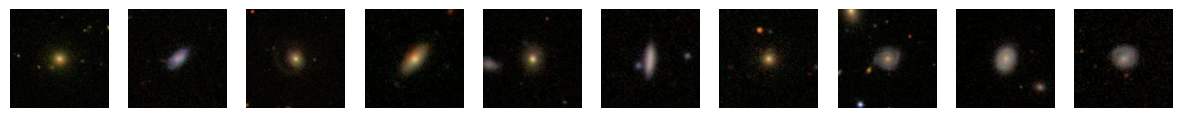

In [28]:
# plot some images from img_root
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    img = cv2.imread(all_images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].axis('off')

In [31]:
# Let us check the image size
sizes = []

for i in range(len(all_images)):
    img = Image.open(all_images[i])
    sizes.append(img.size)

print("前10張圖片尺寸：", sizes[:10])

前10張圖片尺寸： [(424, 424), (424, 424), (424, 424), (424, 424), (424, 424), (424, 424), (424, 424), (424, 424), (424, 424), (424, 424)]


In [33]:
# 你的圖片清單
image_paths = all_images  # 假設你已經跑過 os.walk 拿到所有路徑

# 預設參數
target_size = (64, 64)

# 儲存處理後的圖片
processed_images = []

for path in tqdm(image_paths, desc="Resizing & Normalizing"):
    try:
        img = Image.open(path).convert('RGB')  # 強制轉成 RGB 彩圖
        img = img.resize(target_size, Image.LANCZOS) # Image.LANCZOS 是一種「抗鋸齒」的插值方法（看起來比較不糊）
        img_array = np.asarray(img).astype("float32") # 把 PIL 圖片轉成 NumPy 陣列格式（數字矩陣），並轉為 float32（模型喜歡的數據型別）。
        # float32 是 TensorFlow / PyTorch 標準型別，會加速訓練，也避免溢位問題
        img_array = (img_array / 127.5) - 1.0  # Normalize to [-1, 1]
        processed_images.append(img_array)
    except Exception as e:
        print(f"⚠️ Failed to process {path}: {e}")

# 轉成 NumPy Array
# 把你處理好的一堆圖片合併成一個大的四維陣列 [樣本數, 高度, 寬度, 通道數]
# GAN 或 CNN 要求輸入是一個整批 batch 資料
x_train = np.stack(processed_images)

print("x_train 形狀：", x_train.shape)  # 應該是 (N, 64, 64, 3)
print("資料範圍：", np.min(x_train), "到", np.max(x_train))

Resizing & Normalizing: 100%|██████████| 243434/243434 [14:24<00:00, 281.48it/s]


x_train 形狀： (243434, 64, 64, 3)
資料範圍： -1.0 到 1.0


# GAN

In [ ]:
# Step 1: Storage folders
output_dir = "gan_training_frames_rgb"
model_dir = "saved_models_rgb"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# Step 2: Generator Architecture
def build_generator():
    model = Sequential()

    # We want to make the fully connected layer to be more deeper
    model.add(Dense(256, input_dim = 100))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())

    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())

    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())

    model.add(Dense(2048))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())

    model.add(Dense(4096))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())

    model.add(Dense(8192))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())

    model.add(Dense(4 * 4 * 512))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())

    # Go Con2D Transpose
    model.add(Reshape((4, 4, 512)))

    model.add(Conv2DTranspose(256, 4, strides=2, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(128, 4, strides=2, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64, 4, strides=2, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(3, 4, strides=2, padding="same", activation='tanh'))
    return model

# Step 3: Discriminator Architecture
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, 4, strides=2, padding='same', input_shape=(64, 64, 3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, 4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(256, 4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Conv2D(512, 4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Flatten())

    # We have to add some deep layers
    # But we have to balance the discriminator and generator

    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    # Don't use too many deep layers!

    model.add(Dense(1, activation='sigmoid'))
    return model

# Step 4: GAN Architecture
# The most important step (but others are also important...)
def build_gan(generator, discriminator):

    # We first freeze the discriminator
    discriminator.trainable = False

    # The input of our GAN is a random vector
    # The Latent space size is set to be 100.
    # You will have 100 random numbers

    gan_input = Input(shape=(100,))

    # The generator will create a "fake" image
    fake = generator(gan_input)

    # The discriminator will try to distinguish the fake image
    # The out put of D is a number, i.e., 1 = real; 0 = fake
    gan_output = discriminator(fake)

    return Model(gan_input, gan_output)

# Step 5: Compile
# For each model, we give them their own optimizers
# Note: one model one optimizer!
gen_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
gan_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Build the model
# Create a generator
generator = build_generator()
generator.summary()

# Create a discriminator
discriminator = build_discriminator()
discriminator.summary()

# Create a gan
gan = build_gan(generator, discriminator)

# Compile all of them
generator.compile(loss='binary_crossentropy', optimizer=gen_opt)
discriminator.compile(loss='binary_crossentropy', optimizer=disc_opt, metrics=['accuracy'])
gan.compile(loss='binary_crossentropy', optimizer=gan_opt)

# Step 6: Training Loop

# Because we use self-defined training loop
# We want to know where bugs occur
# Add this line to enforce eager execution
tf.config.run_functions_eagerly(True)

# Training Parameters
epochs = 10000
batch_size = 32
sample_interval = 200
image_frames = []

# Our trianing loop
for epoch in range(epochs):

    # Original version: give real labels to our real data
    # real = np.ones((batch_size, 1))

    # But I do something tricky: label smoothing
    # Why: make the D less confident to discriminate
    real = np.ones((batch_size, 1)) * np.random.uniform(0.9, 1.0)

    # Original:
    #fake = np.zeros((batch_size, 1))
    # make the fake label to be less fake
    fake = np.random.uniform(0.0, 0.1, size=(batch_size, 1))

    # Randomly pick n = batch_size images (32, if you set batch size = 32)
    # Total image number = x_train.shape[0]
    idx = np.random.randint(0, x_train.shape[0], batch_size)

    # Pick up some images according to the idx
    real_imgs = x_train[idx]

    # Create an array consists of 100 random numbers
    noise = np.random.normal(0, 1, (batch_size, 100))

    # Sent the random array into our generator
    gen_imgs = generator.predict(noise)

    # We then train our D by method: train_on_batch
    discriminator.trainable = True
    # Using real images to train
    d_loss_real = discriminator.train_on_batch(real_imgs, real)
    # Using fake images to train
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    # Using average of d_loss_real/fake as an indicator
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Then we train our G
    # We first freez the D
    discriminator.trainable = False

    # We create latent vectors, shape = (batch_size, 100)
    noise = np.random.normal(0, 1, (batch_size, 100))
    # We train G
    # Note: the label must be "real"
    g_loss = gan.train_on_batch(noise, real)

    # Comment: You must not use "gen.train_on_batch(noise, real)"
    # Why? Because the G does not know whether its images are real or not

    # Training monitor
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - D Loss: {d_loss[0]:.4f} - G Loss: {g_loss:.4f}")
        test_noise = np.random.normal(0, 1, (10, 100))
        test_imgs = generator.predict(test_noise)
        fig, axs = plt.subplots(1, 10, figsize=(15, 2))
        for i in range(10):
            axs[i].imshow(((test_imgs[i] + 1) / 2).clip(0, 1))
            axs[i].axis('off')
        plt.tight_layout()
        save_path = os.path.join(output_dir, f"epoch_{epoch:05d}.png")
        plt.savefig(save_path)
        plt.show()
        image_frames.append(imageio.v2.imread(save_path))
        plt.close()

# Step 7: Save results
# Note: You must always record what happened during the training process
# If not, you cannot ... just like somehting right, you know...
imageio.mimsave("training_progress_rgb.gif", image_frames, fps=5)
generator.save(os.path.join(model_dir, "cnn_generator_rgb.h5"))
discriminator.save(os.path.join(model_dir, "cnn_discriminator_rgb.h5"))
gan.save(os.path.join(model_dir, "cnn_gan_rgb.h5"))